**Introduction to the notebook:**

In this notebook, the weather data including weather temperature and wind speed is extracted from free weather API from <https://open-meteo.com/>
Here is a definition for each parameter:


|**Parameter**             |**Definition** [^1]                                                               |**Format**         |
|--------------------------|----------------------------------------------------------------------------------|-------------------|
|`latitude` & `longitude`  |Geographical WGS84 coordinate of the location                                     |Floating point     |
|`start_date` & `end_date` |The time interval to get weather data. A day must be specified as an ISO8601 date.|String (yyyy-mm-dd)|
|`hourly`                  |A list of weather variables which should be returned.                             |String array       |
|`timezone`                |If timezone is set, all timestamps are returned as local-time and data is returned starting at 00:00 local-time.|String             |

**temperature_unit** is in *celsius* and **windspeed_unit** is *kmh*.

**temperature_2m:** Air temperature at 2 meters above ground.

**windspeed_10m & windspeed_100m** Wind speed at 10 or 100 meters above ground. Wind speed on 10 meters is the standard level.


[^1]:Above data is extracted from [API Documentation](https://open-meteo.com/en/docs/historical-weather-api#latitude=51.1657&longitude=10.4515&start_date=2020-01-01&end_date=2023-09-12&hourly=temperature_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m&daily=&timezone=Europe%2FBerlin).

In [1]:
import requests
import json
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
df=pd.read_excel('df.xlsx')

In [3]:
base_URL = "https://archive-api.open-meteo.com/v1/archive"

To get the weather data, first we need to find the center of each ***Postleitzahl***.
Here are the centers based on <https://simple.wikipedia.org/wiki/Postal_codes_in_Germany>:

- 20: Hamburg (53.5507,9.993)
- 21: Hamburg (53.5507,9.993), Elbinsel Wilhelmsburg (53.5067,9.9871), Kirchdorf (52.5952,8.8349), Reinbek (53.517,10.2488), Buchholz in der Nordheide (53.3264,9.8681), Stade (53.5934,9.4763), Freiburg/Elbe (53.8236,9.2854), Balje (53.8333,9.1333)
- 22: Hamburg (53.5507,9.993)
- 23: Lübeck (53.8689,10.6873), Plön (54.1624,10.4233)
- 24: Kiel (54.3213,10.1349), Altenholz (54.4,10.1333), Gettorf (54.4,9.9833), Eckernförde (54.4685,9.8382), Neumünster (54.0748,9.9819), Henstedt-Ulzburg (53.7903,10.0054), Kaltenkirchen (53.8329,9.9581), Bad Bramstedt (53.9183,9.8842), Nortorf (54.1674,9.8544), Hohenwestedt (54.0889,9.6536), Boostedt (54.0167,10.0333), Trappenkamp (54.0399,10.215), Rendsburg (54.3066,9.6631), Büdelsdorf (54.3184,9.673), Flensburg (54.7843,9.4396)
- 25: Uetersen (53.6877,9.6639), Tornesch (53.7,9.7167), Moorrege (53.6667,9.6667), Heidgraben (53.7079,9.681), Groß Nordende (53.7,9.65), Neuendeich (53.6833,9.6167), Marne (54.35,8.7667), Husum (54.4858,9.0524) , Schwabstedt (54.3971,9.1865)
- 26: Bad Zwischenahn (53.1833,8), Wilhelmshaven (53.53,8.1125), Aurich (53.4692,7.4823), Apen (53.2167,7.8), Leer (53.2316,7.461), Moormerland (53.3114,7.423), Rhauderfehn (53.1333,7.6167), Hesel (53.3,7.6), Jemgum (53.2667,7.3833), Elsfleth (53.2375,8.4566)
- 27: Steinkirchen (53.566,9.6111), Hollern-Twielenfleth (53.5998,9.5522)
- 28: Bremen (53.0758,8.8072)
- 48: Münster (51.9624,7.6257), Dülmen and the district of Hiddingsel (51.8315,7.2808), Telgte (51.98,7.7829), Everswinkel (51.926,7.8469), Billerbeck (51.9783,7.2926), Hörstel (52.2976,7.5838), Ibbenbüren (52.2796,7.7146)
- 49: Osnabrück (52.2726,8.0498), Georgsmarienhütte (52.203,8.0448), Hagen am Teutoburger Wald (52.1963,7.9804), Hilter am Teutoburger Wald (52.1357,8.1471), Bad Iburg (52.1549,8.0422), Bad Laer(52.1,8.0833), Dissen am Teutoburger Wald (52.1159,8.1996), Bad Rothenfelde (52.1167,8.1667), Glandorf (52.0847,7.9994), Ibbenbüren (Nordrhein-Westfalen) (52.2796,7.7146)


In [4]:
# Coordinates for each Postleitzahl

coordinates_20212223 = [{'latitude':53.5507 , 'longitude':9.993},
                        {'latitude':53.5067 , 'longitude':9.9871},
                        {'latitude':52.5952 , 'longitude':8.8349},
                        {'latitude':53.517 , 'longitude':10.2488},
                        {'latitude':53.3264 , 'longitude':9.8681},
                        {'latitude':53.5934 , 'longitude':9.4763},
                        {'latitude':53.8236 , 'longitude':9.2854},
                        {'latitude':53.8333 , 'longitude':9.1333},
                        {'latitude':53.8689 , 'longitude':10.6873},
                        {'latitude':54.1624 , 'longitude':10.4233}]

coordinates_2425 = [{'latitude':54.3213 , 'longitude':10.1349},
                        {'latitude':54.4 , 'longitude':10.1333},
                        {'latitude':54.4 , 'longitude':9.9833},
                        {'latitude':54.4685 , 'longitude':9.8382},
                        {'latitude':54.0748 , 'longitude':9.9819},
                        {'latitude':53.7903 , 'longitude':10.0054},
                        {'latitude':53.8329 , 'longitude':9.9581},
                        {'latitude':53.9183 , 'longitude':9.8842},
                        {'latitude':54.1674 , 'longitude':9.8544},
                        {'latitude':54.0889 , 'longitude':9.6536},
                        {'latitude':54.0167 , 'longitude':10.0333},
                        {'latitude':54.0399 , 'longitude':10.215},
                        {'latitude':54.3066 , 'longitude':9.6631},
                        {'latitude':54.3184 , 'longitude':9.673},
                        {'latitude':54.7843 , 'longitude':9.4396},
                        {'latitude':53.6877 , 'longitude':9.6639},
                        {'latitude':53.7 , 'longitude':9.7167},
                        {'latitude':53.6667 , 'longitude':9.6667},
                        {'latitude':53.7079 , 'longitude':9.681},
                        {'latitude':53.7 , 'longitude':9.65},
                        {'latitude':53.6833 , 'longitude':9.6167},
                        {'latitude':54.35 , 'longitude':8.7667},
                        {'latitude':54.4858 , 'longitude':9.0524},
                        {'latitude':54.3971 , 'longitude':9.1865}]

coordinates_262728 = [{'latitude':53.1833 , 'longitude':8},
                        {'latitude':53.53 , 'longitude':8.1125},
                        {'latitude':53.4692 , 'longitude':7.4823},
                        {'latitude':53.2167 , 'longitude':7.8},
                        {'latitude':53.2316 , 'longitude':7.461},
                        {'latitude':53.3114 , 'longitude':7.423},
                        {'latitude':53.1333 , 'longitude':7.6167},
                        {'latitude':53.3 , 'longitude':7.6},
                        {'latitude':53.2667 , 'longitude':7.3833},
                        {'latitude':53.2375 , 'longitude':8.4566},
                        {'latitude':53.566 , 'longitude':9.6111},
                        {'latitude':53.5998 , 'longitude':9.5522},
                        {'latitude':53.0758 , 'longitude':8.8072}]

coordinates_4849 = [{'latitude':51.9624 , 'longitude':7.6257},
                        {'latitude':51.8315 , 'longitude':7.2808},
                        {'latitude':51.98 , 'longitude':7.7829},
                        {'latitude':51.926 , 'longitude':7.8469},
                        {'latitude':51.9783 , 'longitude':7.2926},
                        {'latitude':52.2976 , 'longitude':7.5838},
                        {'latitude':52.2796 , 'longitude':7.7146},
                        {'latitude':52.2726 , 'longitude':8.0498},
                        {'latitude':52.203 , 'longitude':8.0448},
                        {'latitude':52.1963 , 'longitude':7.9804},
                        {'latitude':52.1357 , 'longitude':8.1471},
                        {'latitude':52.1549 , 'longitude':8.0422},
                        {'latitude':52.1 , 'longitude':8.0833},
                        {'latitude':52.1159 , 'longitude':8.1996},
                        {'latitude':52.1167 , 'longitude':8.1667},
                        {'latitude':52.0847 , 'longitude':7.9994},
                        {'latitude':52.2796 , 'longitude':7.7146}]


In [5]:
def weather_data(coordinates):
    '''
    This function takes a set of defined coordinates as input and provides the weather data of these coordinates, then takes an average
    of the weather data for all the coordinates and creates a dataset and then converts the hourly data into weekly data.
    '''
    params = {
    'start_date': '2020-09-01',
    'end_date': '2023-09-05',
    'hourly': {'temperature_2m', 'windspeed_10m'},
    'timezone': 'Europe/Berlin',
    }

    # number = coordinates.split('_')[1]
    dataframes = {}
    for i, coordinate in enumerate(coordinates):
        params.update(coordinate)
        response = requests.get(base_URL, params=params)
        if response.status_code == 200:
            data = response.json()
            df_name = f'df_{i}'
            dataframes[df_name] = pd.DataFrame(data['hourly'])
            dataframes[df_name]['time'] = pd.to_datetime(dataframes[df_name]['time'], format='%Y-%m-%dT%H:%M')
        else:
            print("Error: Status code {}".format(response.status_code))
        for key in coordinate:
            del params[key]

    # combining datasets of all coorsinates together and take the average of them for each hour
    combined_df = pd.concat(dataframes)
    averaged_df = combined_df.groupby('time').mean().reset_index()

    # converting the hourly dataset into weekly dataset by taking the average of each week
    weekley_df = averaged_df.groupby(pd.Grouper(key='time',freq='W')).mean().reset_index()
    weekley_df['time'] = weekley_df['time'].dt.to_period('W').dt.start_time
    weekley_df['time'] = pd.to_datetime(weekley_df['time'])

    return weekley_df

In [6]:
w_20212223 = weather_data(coordinates_20212223)
file_path = 'w_20212223.csv'
w_20212223.to_csv(file_path,index=False)

In [7]:
w_2425 = weather_data(coordinates_2425)
file_path = 'w_2425.csv'
w_2425.to_csv(file_path,index=False)

In [8]:
w_262728 = weather_data(coordinates_262728)
file_path = 'w_262728.csv'
w_262728.to_csv(file_path,index=False)

In [9]:
w_4849 = weather_data(coordinates_4849)
file_path = 'w_4849.csv'
w_4849.to_csv(file_path,index=False)

In [10]:
def weather_lag_data(coordinates):
    '''
    This function takes a set of defined coordinates as input and provides the weather data of these coordinates with one month lag, then takes an average
    of the weather data for all the coordinates and creates a dataset and then converts the hourly data into weekly data.
    '''
    params = {
    'start_date': '2020-08-01',
    'end_date': '2023-08-05',
    'hourly': {'temperature_2m', 'windspeed_10m'},
    'timezone': 'Europe/Berlin',
    }

    # number = coordinates.split('_')[1]
    dataframes = {}
    for i, coordinate in enumerate(coordinates):
        params.update(coordinate)
        response = requests.get(base_URL, params=params)
        if response.status_code == 200:
            data = response.json()
            df_name = f'df_{i}'
            dataframes[df_name] = pd.DataFrame(data['hourly'])
            dataframes[df_name]['time'] = pd.to_datetime(dataframes[df_name]['time'], format='%Y-%m-%dT%H:%M')
        else:
            print("Error: Status code {}".format(response.status_code))
        for key in coordinate:
            del params[key]

    # combining datasets of all coorsinates together and take the average of them for each hour
    combined_df = pd.concat(dataframes)
    averaged_df = combined_df.groupby('time').mean().reset_index()

    # converting the hourly dataset into weekly dataset by taking the average of each week
    weekley_df = averaged_df.groupby(pd.Grouper(key='time',freq='W')).mean().reset_index()
    weekley_df['time'] = weekley_df['time'].dt.to_period('W').dt.start_time
    weekley_df['time'] = pd.to_datetime(weekley_df['time'])
    weekley_df['time_lag'] = weekley_df['time'] + pd.DateOffset(weeks=4)

    return weekley_df

In [14]:
wl_20212223 = weather_lag_data(coordinates_20212223)
#file_path = 'wl_20212223.csv'
#wl_20212223.to_csv(file_path,index=False)

In [15]:
wl_2425 = weather_lag_data(coordinates_2425)
#file_path = 'wl_2425.csv'
#wl_2425.to_csv(file_path,index=False)

In [16]:
wl_262728 = weather_lag_data(coordinates_262728)
#file_path = 'wl_262728.csv'
#wl_262728.to_csv(file_path,index=False)

In [39]:
wl_4849 = weather_lag_data(coordinates_4849)
#file_path = 'wl_4849.csv'
#wl_4849.to_csv(file_path,index=False)

In [40]:
wl_20212223.head()

,time,temperature_2m,windspeed_10m,time_lag
0,2020-07-27,20.150208,11.275208,2020-08-24
1,2020-08-03,21.562381,9.347262,2020-08-31
2,2020-08-10,24.535655,11.036607,2020-09-07
3,2020-08-17,21.238393,11.122679,2020-09-14
4,2020-08-24,16.181369,14.080238,2020-09-21


In [41]:
wl_20212223.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            158 non-null    datetime64[ns]
 1   temperature_2m  158 non-null    float64       
 2   windspeed_10m   158 non-null    float64       
 3   time_lag        158 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(2)
memory usage: 5.1 KB


## Loading the Weather datasets and selecting the timeseries for each product categories

In [42]:
# w_20212223 = pd.read_csv('w_20212223.csv')
# wl_20212223 = pd.read_csv('wl_20212223.csv')
A1A2_20212223 = df[(df['Plz'] == "['20', '21', '22', '23']") & (df['full'] == "A1 & A2 -  geschreddert")]

In [43]:
# w_2425 = pd.read_csv('w_2425.csv')
# w_2425 = pd.read_csv('w_2425.csv')
A2_2425 = df[(df['Plz'] == "['25', '24']") & (df['full'] == "A2 -  geschreddert")]

In [44]:
# w_262728 = pd.read_csv('w_262728.csv')
# wl_262728 = pd.read_csv('wl_262728.csv')
A2A3_262728 = df[(df['Plz'] == "['26', '27', '28']") & (df['full'] == "A2 & A3 -  geschreddert")]

In [45]:
# w_4849 = pd.read_csv('w_4849.csv')
# wl_4849 = pd.read_csv('wl_4849.csv')
A3_4849= df[(df['Plz'] == "['48', '49']") & (df['full'] == "A3 -  geschreddert")]

## Combining the datasets and visualising the time series



In this part of the notebook, we will combine each of the weather determinanit datasets with a specific product category in a selected cluster. Then we plot the timeseries to see if it depicts any correlation between wPreis variable and windspeed and temperature variables. We do this for the both normal weather determinants and those with 1 month lag.
Based on the visualisations, we can understand that temperature has a seasonal trend and wind has too much fluctuations.
In the time between December 2021 and August 2022, it seems that the weather temperature and weeklee price are bothe increasing. However the increase in weekly price was started from July 2021, when we had decrease in temperature due to changing season.
In this stage, we can not deduce that there would be a correlatin between weather determinants and weighted price.

### Combined dataset for A1 and A2 category and weather determinants

In [46]:
wd_A1A2_20212223 = pd.merge(A1A2_20212223[['date', 'full', 'wPreis']],
                            w_20212223[['time', 'windspeed_10m','temperature_2m']],
                            left_on='date', right_on='time', how='inner')
wd_A1A2_20212223 = wd_A1A2_20212223.drop(columns='time')
wd_A1A2_20212223.head()

,date,full,wPreis,windspeed_10m,temperature_2m
0,2020-09-14,A1 & A2 - geschreddert,-33.575183,9.828214,15.897143
1,2020-09-21,A1 & A2 - geschreddert,-30.469655,10.337440,14.293631
2,2020-09-28,A1 & A2 - geschreddert,-31.289522,13.442738,13.913393
3,2020-10-05,A1 & A2 - geschreddert,-30.616354,16.193452,11.236071
4,2020-10-12,A1 & A2 - geschreddert,-31.291948,12.087143,8.940238


### Visualising the time series for A1 and A2 categoriy

In [47]:
fig = px.line(wd_A1A2_20212223, x='date', y=['wPreis','temperature_2m','windspeed_10m'], title='All the timeseries at a glance for A1 & A2 product category', width=1500)
fig.show()

In [48]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("wPreis", "Temperature", "Windspeed"))

fig.add_trace(go.Scatter(x=wd_A1A2_20212223.date, y=wd_A1A2_20212223.wPreis, mode='lines', name='wPreis'), row=1, col=1)
fig.add_trace(go.Scatter(x=wd_A1A2_20212223.date, y=wd_A1A2_20212223.temperature_2m, mode='lines', name='Temperature'), row=2, col=1)
fig.add_trace(go.Scatter(x=wd_A1A2_20212223.date, y=wd_A1A2_20212223.windspeed_10m, mode='lines', name='Windspeed'), row=3, col=1)

fig.update_yaxes(title_text="Price", row=1, col=1, range=[-50, 100])
fig.update_yaxes(title_text="temperature in celsius", row=2, col=1, range=[-10, 40])
fig.update_yaxes(title_text="wind in Kmh", row=3, col=1, range=[0, 30])

fig.update_layout(height=700, width=800, title_text="Timeseres for A1 & A2 product category")

fig.show()


### Combined dataset for A1 and A2 category and weather determinants with 1 month lag

In [49]:
wdl_A1A2_20212223 = pd.merge(A1A2_20212223[['date', 'wPreis', 'full']],
                             wl_20212223[['time', 'windspeed_10m', 'temperature_2m','time_lag']],
                             left_on='date', right_on='time_lag', how='inner')
wdl_A1A2_20212223 = wdl_A1A2_20212223.drop(columns=['time','time_lag'])
wdl_A1A2_20212223.head()

,date,wPreis,full,windspeed_10m,temperature_2m
0,2020-09-14,-33.575183,A1 & A2 - geschreddert,11.122679,21.238393
1,2020-09-21,-30.469655,A1 & A2 - geschreddert,14.080238,16.181369
2,2020-09-28,-31.289522,A1 & A2 - geschreddert,11.728929,15.149226
3,2020-10-05,-30.616354,A1 & A2 - geschreddert,13.736131,15.696012
4,2020-10-12,-31.291948,A1 & A2 - geschreddert,9.828214,15.897143


### Visualising the time series for A1 and A2 categoriy with 1 month lag in weather determinants

In [50]:
fig = px.line(wdl_A1A2_20212223, x='date', y=['wPreis','temperature_2m','windspeed_10m'], title='All the timeseries at a glance for A1 & A2 product category with 1 month lag in weather determinant', width=1500)
fig.show()

In [51]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("wPreis", "Temperature", "Windspeed"))

fig.add_trace(go.Scatter(x=wdl_A1A2_20212223.date, y=wdl_A1A2_20212223.wPreis, mode='lines', name='wPreis'), row=1, col=1)
fig.add_trace(go.Scatter(x=wdl_A1A2_20212223.date, y=wdl_A1A2_20212223.temperature_2m, mode='lines', name='Temperature'), row=2, col=1)
fig.add_trace(go.Scatter(x=wdl_A1A2_20212223.date, y=wdl_A1A2_20212223.windspeed_10m, mode='lines', name='Windspeed'), row=3, col=1)

fig.update_yaxes(title_text="Price", row=1, col=1, range=[-50, 100])
fig.update_yaxes(title_text="temperature in celsius", row=2, col=1, range=[-10, 40])
fig.update_yaxes(title_text="wind in Kmh", row=3, col=1, range=[0, 30])

fig.update_layout(height=700, width=800, title_text="Timeseres for A1 & A2 product category with 1 month lag in weather determinant")

fig.show()


### Combined dataset for A2 category and weather determinants

In [52]:
wd_A2_2425 = pd.merge(A2_2425[['date', 'full', 'wPreis']],
                            w_2425[['time', 'windspeed_10m','temperature_2m']],
                            left_on='date', right_on='time', how='inner')
wd_A2_2425 = wd_A2_2425.drop(columns='time')
wd_A2_2425.head()

,date,full,wPreis,windspeed_10m,temperature_2m
0,2020-09-14,A2 - geschreddert,-37.519318,9.461508,15.376488
1,2020-09-28,A2 - geschreddert,-40.000000,14.531374,14.034127
2,2020-10-12,A2 - geschreddert,-34.853543,12.588170,8.956200
3,2020-10-19,A2 - geschreddert,-27.560202,18.018304,11.914732
4,2020-10-26,A2 - geschreddert,-31.937780,17.717758,11.118254


### Visualising the time series for A2 categoriy

In [53]:
fig = px.line(wd_A2_2425, x='date', y=['wPreis','temperature_2m','windspeed_10m'], title='All the timeseries at a glance for A2 product category', width=1500)
fig.show()

In [54]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("wPreis", "Temperature", "Windspeed"))

fig.add_trace(go.Scatter(x=wd_A2_2425.date, y=wd_A2_2425.wPreis, mode='lines', name='wPreis'), row=1, col=1)
fig.add_trace(go.Scatter(x=wd_A2_2425.date, y=wd_A2_2425.temperature_2m, mode='lines', name='Temperature'), row=2, col=1)
fig.add_trace(go.Scatter(x=wd_A2_2425.date, y=wd_A2_2425.windspeed_10m, mode='lines', name='Windspeed'), row=3, col=1)

fig.update_yaxes(title_text="Price", row=1, col=1, range=[-50, 100])
fig.update_yaxes(title_text="temperature in celsius", row=2, col=1, range=[-10, 40])
fig.update_yaxes(title_text="wind in Kmh", row=3, col=1, range=[0, 30])

fig.update_layout(height=700, width=800, title_text="Timeseres for A2 product category")

fig.show()


### Combined dataset for A2 category and weather determinants with 1 month lag

In [55]:
wdl_A2_2425 = pd.merge(A2_2425[['date', 'wPreis', 'full']],
                             wl_2425[['time', 'windspeed_10m', 'temperature_2m','time_lag']],
                             left_on='date', right_on='time_lag', how='inner')
wdl_A2_2425 = wdl_A2_2425.drop(columns=['time','time_lag'])
wdl_A2_2425.head()

,date,wPreis,full,windspeed_10m,temperature_2m
0,2020-09-14,-37.519318,A2 - geschreddert,12.269048,21.023760
1,2020-09-28,-40.000000,A2 - geschreddert,12.554067,14.928075
2,2020-10-12,-34.853543,A2 - geschreddert,9.461508,15.376488
3,2020-10-19,-27.560202,A2 - geschreddert,10.715501,14.164906
4,2020-10-26,-31.937780,A2 - geschreddert,14.531374,14.034127


### Visualising the time series for A2 categoriy with 1 month lag in weather determinant



In [56]:
fig = px.line(wdl_A2_2425, x='date', y=['wPreis','temperature_2m','windspeed_10m'], title='All the timeseries at a glance for A2 product category with 1 month lag in weather determinant', width=1500)
fig.show()

In [57]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("wPreis", "Temperature", "Windspeed"))

fig.add_trace(go.Scatter(x=wdl_A2_2425.date, y=wdl_A2_2425.wPreis, mode='lines', name='wPreis'), row=1, col=1)
fig.add_trace(go.Scatter(x=wdl_A2_2425.date, y=wdl_A2_2425.temperature_2m, mode='lines', name='Temperature'), row=2, col=1)
fig.add_trace(go.Scatter(x=wdl_A2_2425.date, y=wdl_A2_2425.windspeed_10m, mode='lines', name='Windspeed'), row=3, col=1)

fig.update_yaxes(title_text="Price", row=1, col=1, range=[-50, 100])
fig.update_yaxes(title_text="temperature in celsius", row=2, col=1, range=[-10, 40])
fig.update_yaxes(title_text="wind in Kmh", row=3, col=1, range=[0, 30])

fig.update_layout(height=700, width=800, title_text="Timeseres for A2 product category with 1 month lag in weather determinant")

fig.show()


### Combined dataset for A2 and A3 category and weather determinants

In [58]:
wd_A2A3_262728 = pd.merge(A2A3_262728[['date', 'full', 'wPreis']],
                            w_262728[['time', 'windspeed_10m','temperature_2m']],
                            left_on='date', right_on='time', how='inner')
wd_A2A3_262728 = wd_A2A3_262728.drop(columns='time')
wd_A2A3_262728.head()

,date,full,wPreis,windspeed_10m,temperature_2m
0,2020-09-14,A2 & A3 - geschreddert,-29.257568,10.843498,15.949771
1,2020-09-21,A2 & A3 - geschreddert,-31.281060,11.294643,14.095421
2,2020-09-28,A2 & A3 - geschreddert,-32.255530,14.582280,13.870650
3,2020-10-05,A2 & A3 - geschreddert,-28.939862,17.145833,11.130952
4,2020-10-12,A2 & A3 - geschreddert,-30.470931,11.297802,9.092170


### Visualising the time series for A2 & A3 categoriy

In [59]:
fig = px.line(wd_A2A3_262728, x='date', y=['wPreis','temperature_2m','windspeed_10m'], title='All the timeseries at a glance for A2 & A3 product category', width=1500)
fig.show()

### Visualising the time series for A2 & A3 categoriy

In [60]:
fig = px.line(wd_A2A3_262728, x='date', y=['wPreis','temperature_2m','windspeed_10m'], title='All the timeseries at a glance for A2 & A3 product category', width=1500)
fig.show()

### Combined dataset for A2 and A3 category and weather determinants with 1 month lag

In [61]:
wdl_A2A3_262728 = pd.merge(A2A3_262728[['date', 'wPreis', 'full']],
                             wl_262728[['time', 'windspeed_10m', 'temperature_2m','time_lag']],
                             left_on='date', right_on='time_lag', how='inner')
wdl_A2A3_262728 = wdl_A2A3_262728.drop(columns=['time','time_lag'])
wdl_A2A3_262728.head()

,date,wPreis,full,windspeed_10m,temperature_2m
0,2020-09-14,-29.257568,A2 & A3 - geschreddert,12.453984,20.634615
1,2020-09-21,-31.281060,A2 & A3 - geschreddert,15.702473,16.075046
2,2020-09-28,-32.255530,A2 & A3 - geschreddert,11.203571,14.936996
3,2020-10-05,-28.939862,A2 & A3 - geschreddert,13.409341,15.501603
4,2020-10-12,-30.470931,A2 & A3 - geschreddert,10.843498,15.949771


### Visualising the time series for A2 & A3 categoriy with 1 month lag in weather determinant



In [62]:
fig = px.line(wdl_A2A3_262728, x='date', y=['wPreis','temperature_2m','windspeed_10m'], title='All the timeseries at a glance for A2 & A3 product category with 1 month lag in weather determinant', width=1500)
fig.show()

In [63]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("wPreis", "Temperature", "Windspeed"))

fig.add_trace(go.Scatter(x=wdl_A2A3_262728.date, y=wdl_A2A3_262728.wPreis, mode='lines', name='wPreis'), row=1, col=1)
fig.add_trace(go.Scatter(x=wdl_A2A3_262728.date, y=wdl_A2A3_262728.temperature_2m, mode='lines', name='Temperature'), row=2, col=1)
fig.add_trace(go.Scatter(x=wdl_A2A3_262728.date, y=wdl_A2A3_262728.windspeed_10m, mode='lines', name='Windspeed'), row=3, col=1)

fig.update_yaxes(title_text="Price", row=1, col=1, range=[-50, 100])
fig.update_yaxes(title_text="temperature in celsius", row=2, col=1, range=[-10, 40])
fig.update_yaxes(title_text="wind in Kmh", row=3, col=1, range=[0, 30])

fig.update_layout(height=700, width=800, title_text="Timeseres for A2 & A3 product category with 1 month lag in weather determinant")

fig.show()


### Combined dataset for A3 category and weather determinants

In [64]:
wd_A3_4849 = pd.merge(A3_4849[['date', 'full', 'wPreis']],
                            w_4849[['time', 'windspeed_10m','temperature_2m']],
                            left_on='date', right_on='time', how='inner')
wd_A3_4849 = wd_A3_4849.drop(columns='time')
wd_A3_4849.head()

,date,full,wPreis,windspeed_10m,temperature_2m
0,2020-09-14,A3 - geschreddert,-29.244584,11.126611,17.276611
1,2020-09-21,A3 - geschreddert,-27.878925,11.232703,14.743417
2,2020-09-28,A3 - geschreddert,-25.077400,13.299230,13.408018
3,2020-10-05,A3 - geschreddert,-25.663645,16.817542,11.093627
4,2020-10-12,A3 - geschreddert,-24.004958,10.245553,8.643943


### Visualising the time series for A3 categoriy

In [65]:
fig = px.line(wd_A3_4849, x='date', y=['wPreis','temperature_2m','windspeed_10m'], title='All the timeseries at a glance for A3 product category', width=1500)
fig.show()

In [66]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("wPreis", "Temperature", "Windspeed"))

fig.add_trace(go.Scatter(x=wd_A3_4849.date, y=wd_A3_4849.wPreis, mode='lines', name='wPreis'), row=1, col=1)
fig.add_trace(go.Scatter(x=wd_A3_4849.date, y=wd_A3_4849.temperature_2m, mode='lines', name='Temperature'), row=2, col=1)
fig.add_trace(go.Scatter(x=wd_A3_4849.date, y=wd_A3_4849.windspeed_10m, mode='lines', name='Windspeed'), row=3, col=1)

fig.update_yaxes(title_text="Price", row=1, col=1, range=[-50, 100])
fig.update_yaxes(title_text="temperature in Celsius", row=2, col=1, range=[-10, 40])
fig.update_yaxes(title_text="wind in Kmh", row=3, col=1, range=[0, 30])

fig.update_layout(height=700, width=800, title_text="Timeseres for A3 product category")

fig.show()


### Combined dataset for A3 category and weather determinants with 1 month lag

In [67]:
wdl_A3_4849 = pd.merge(A3_4849[['date', 'wPreis', 'full']],
                             wl_4849[['time', 'windspeed_10m', 'temperature_2m','time_lag']],
                             left_on='date', right_on='time_lag', how='inner')
wdl_A3_4849 = wdl_A3_4849.drop(columns=['time','time_lag'])
wdl_A3_4849.head()

,date,wPreis,full,windspeed_10m,temperature_2m
0,2020-09-14,-29.244584,A3 - geschreddert,11.792962,20.836169
1,2020-09-21,-27.878925,A3 - geschreddert,15.275280,16.488410
2,2020-09-28,-25.077400,A3 - geschreddert,10.416702,15.215966
3,2020-10-05,-25.663645,A3 - geschreddert,10.120168,15.856513
4,2020-10-12,-24.004958,A3 - geschreddert,11.126611,17.276611


### Visualising the time series for A3 categoriy with 1 month lag in weather determinant



In [68]:
fig = px.line(wdl_A3_4849, x='date', y=['wPreis','temperature_2m','windspeed_10m'], title='All the timeseries at a glance for A3 product category with 1 month lag in weather determinant', width=1500)
fig.show()

In [69]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("wPreis", "Temperature", "Windspeed"))

fig.add_trace(go.Scatter(x=wdl_A3_4849.date, y=wdl_A3_4849.wPreis, mode='lines', name='wPreis'), row=1, col=1)
fig.add_trace(go.Scatter(x=wdl_A3_4849.date, y=wdl_A3_4849.temperature_2m, mode='lines', name='Temperature'), row=2, col=1)
fig.add_trace(go.Scatter(x=wdl_A3_4849.date, y=wdl_A3_4849.windspeed_10m, mode='lines', name='Windspeed'), row=3, col=1)

fig.update_yaxes(title_text="Price", row=1, col=1, range=[-50, 100])
fig.update_yaxes(title_text="temperature in Celsius", row=2, col=1, range=[-10, 40])
fig.update_yaxes(title_text="wind in Kmh", row=3, col=1, range=[0, 30])

fig.update_layout(height=700, width=800, title_text="Timeseres for A3 product category with 1 month lag in weather determinant")

fig.show()


## Correlation Matrix of each product category and weather determinants

As we noticed in previous plots, there was not a simultaneous increasing or decreasing in weekly price and weather determinants timeseries. However, in the following, we calculated the correlation coefficient between these variables. Based on the correlation coefficients, again we can infer that there is not a meaningful correlation between weighted price and weather determinants.

In [70]:
correlation_A1A2 = wd_A1A2_20212223[['wPreis', 'windspeed_10m','temperature_2m']].corr()
correlation_A1A2_lag = wdl_A1A2_20212223[['wPreis', 'windspeed_10m','temperature_2m']].corr()
correlation_A2 = wd_A2_2425[['wPreis', 'windspeed_10m','temperature_2m']].corr()
correlation_A2_lag = wdl_A2_2425[['wPreis', 'windspeed_10m','temperature_2m']].corr()
correlation_A2A3 = wd_A2A3_262728[['wPreis', 'windspeed_10m','temperature_2m']].corr()
correlation_A2A3_lag = wdl_A2A3_262728[['wPreis', 'windspeed_10m','temperature_2m']].corr()
correlation_A3 = wd_A3_4849[['wPreis', 'windspeed_10m','temperature_2m']].corr()
correlation_A3_lag = wdl_A3_4849[['wPreis', 'windspeed_10m','temperature_2m']].corr()

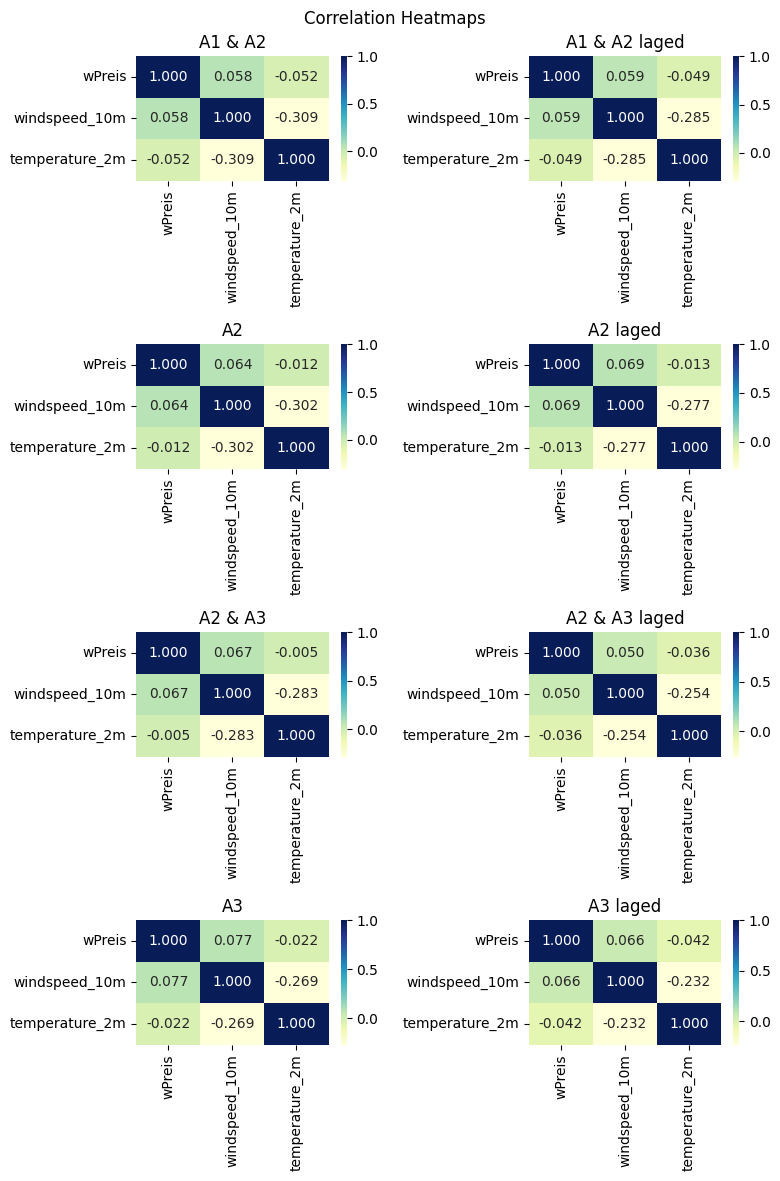

In [71]:
# Sample heatmap data (replace with your actual data)
correlation_matrices = [correlation_A1A2, correlation_A1A2_lag, correlation_A2, correlation_A2_lag,
                       correlation_A2A3, correlation_A2A3_lag, correlation_A3, correlation_A3_lag]

matrix_names = ["A1 & A2", "A1 & A2 laged", "A2", "A2 laged", "A2 & A3", "A2 & A3 laged", "A3", "A3 laged"]

fig, axes = plt.subplots(4, 2, figsize=(8, 12))
fig.suptitle("Correlation Heatmaps")

for i, corr_matrix in enumerate(correlation_matrices):
    ax = axes[i // 2, i % 2]
    sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap="YlGnBu", ax=ax)
    ax.set_title(matrix_names[i])

plt.tight_layout()
plt.show()
